## Importing the necessary libraries

In [1]:
import os
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.image import imread
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, save_model
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam 
import tensorflow_hub as hub
from tensorflow.keras.preprocessing import image

## Getting the path of the training and testing data of the brain tumor dataset

In [2]:
dataset_directory_location = 'image_dataset'

In [3]:
os.listdir(dataset_directory_location)

['test', 'train']

In [4]:
train_dataset_location = os.path.join(dataset_directory_location, 'train')
test_dataset_location = os.path.join(dataset_directory_location, 'test')

In [5]:
os.listdir(train_dataset_location)

['leaf', 'not_leaf']

In [6]:
os.listdir(test_dataset_location)

['leaf', 'not_leaf']

## Viewing a brain image

In [7]:
image_sample = os.path.join(train_dataset_location, 'not_leaf')

In [8]:
os.listdir(image_sample)[:1]

['100069.png']

In [9]:
image_sample_read = imread(os.path.join(image_sample, '100069.png'))

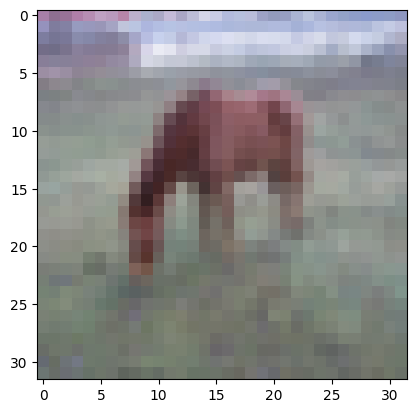

In [10]:
plt.imshow(image_sample_read)

In [11]:
image_sample_read.shape 

(32, 32, 3)

## Defining the correct shape of the image

In [12]:
correct_image_shape = (224, 224, 3)

## Defining the ImageGenerator and performing Data Augmentation

In [13]:
image_gen = ImageDataGenerator(rotation_range=20, 
                               width_shift_range=0.1, 
                               height_shift_range=0.1, 
                               shear_range=0.1, 
                               zoom_range=0.1, 
                               horizontal_flip=True, 
                               fill_mode='nearest',
                               rescale=1./255)

In [14]:
train_image_gen = image_gen.flow_from_directory(train_dataset_location, 
                                                target_size=correct_image_shape[:2], 
                                                color_mode='rgb', 
                                                batch_size=16, 
                                                class_mode='binary')

test_image_gen = image_gen.flow_from_directory(test_dataset_location, 
                                                target_size=correct_image_shape[:2], 
                                                color_mode='rgb', 
                                                batch_size=16, 
                                                class_mode='binary')

Found 10000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


## Creating and training the model

In [15]:
model = Sequential()

In [16]:
get_inception_v2_pretrained_model = "https://www.kaggle.com/models/google/inception-v2/TensorFlow2/classification/2"

In [17]:
inception_v2_pretrained_model = hub.KerasLayer(get_inception_v2_pretrained_model, input_shape=correct_image_shape, trainable=False) 

In [18]:
model.add(inception_v2_pretrained_model)

model.add(Dense(1, activation='sigmoid'))

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1001)              11199137  
                                                                 
 dense (Dense)               (None, 1)                 1002      
                                                                 
Total params: 11,200,139
Trainable params: 1,002
Non-trainable params: 11,199,137
_________________________________________________________________


In [20]:
model.compile(loss=BinaryCrossentropy(), optimizer=Adam(learning_rate=0.00001), metrics=['accuracy'])

In [21]:
model.fit(train_image_gen, validation_data=test_image_gen, epochs=10)

Epoch 1/10
625/625 [==============================] - 200s 295ms/step - loss: 0.5921 - accuracy: 0.6892 - val_loss: 0.3030 - val_accuracy: 0.9215
Epoch 2/10
625/625 [==============================] - 169s 271ms/step - loss: 0.2022 - accuracy: 0.9601 - val_loss: 0.1330 - val_accuracy: 0.9860
Epoch 3/10
625/625 [==============================] - 165s 265ms/step - loss: 0.1015 - accuracy: 0.9891 - val_loss: 0.0779 - val_accuracy: 0.9915
Epoch 4/10
625/625 [==============================] - 157s 251ms/step - loss: 0.0603 - accuracy: 0.9953 - val_loss: 0.0483 - val_accuracy: 0.9950
Epoch 5/10
625/625 [==============================] - 180s 287ms/step - loss: 0.0402 - accuracy: 0.9975 - val_loss: 0.0316 - val_accuracy: 0.9990
Epoch 6/10
625/625 [==============================] - 160s 257ms/step - loss: 0.0286 - accuracy: 0.9980 - val_loss: 0.0276 - val_accuracy: 0.9960
Epoch 7/10
625/625 [==============================] - 156s 250ms/step - loss: 0.0199 - accuracy: 0.9989 - val_loss: 0.0169 -

In [22]:
history_df = pd.DataFrame(model.history.history)

<Axes: >

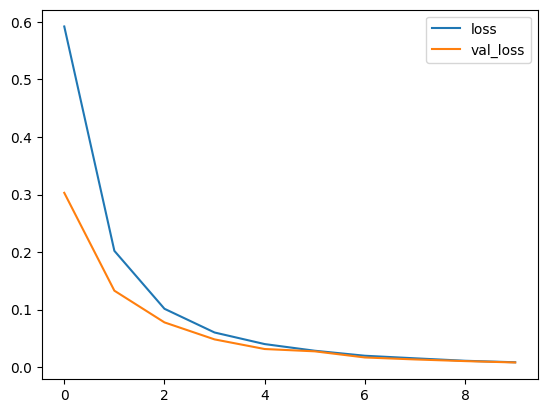

In [23]:
history_df[['loss', 'val_loss']].plot()

<Axes: >

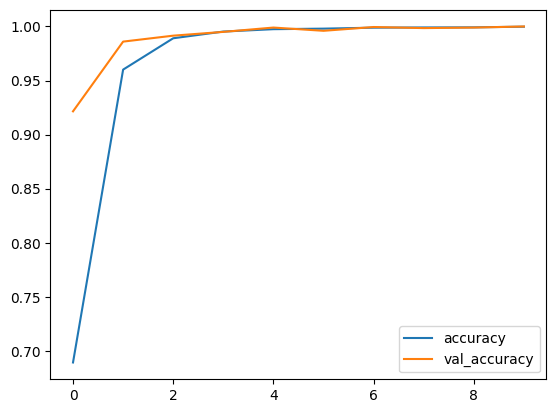

In [24]:
history_df[['accuracy', 'val_accuracy']].plot()

## Evaluating the model

In [25]:
model.evaluate(train_image_gen)[1]

625/625 [==============================] - 145s 231ms/step - loss: 0.0080 - accuracy: 0.9998


0.9998000264167786

In [26]:
model.evaluate(test_image_gen)[1]

125/125 [==============================] - 32s 253ms/step - loss: 0.0106 - accuracy: 0.9985


0.9984999895095825

## Predicting on a sample image

In [27]:
sample_img_load = image.load_img('./image_dataset/test/not_leaf/250627.png', target_size=correct_image_shape)

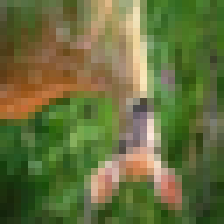

In [28]:
sample_img_load

In [29]:
sample_img_to_arr = image.img_to_array(sample_img_load) 

In [30]:
sample_img_to_arr = image.img_to_array(sample_img_load) / 255

In [31]:
sample_img_to_arr_expand_dim = np.expand_dims(sample_img_to_arr, 0) 

In [32]:
prediction = (model.predict(sample_img_to_arr_expand_dim) > 0.5).astype('int32')

1/1 [==============================] - 2s 2s/step


In [33]:
class_names = ['leaf', 'not_leaf']

In [34]:
pred_final_result = class_names[prediction[0][0]]

In [35]:
pred_final_result

'not_leaf'

## Save the model

In [36]:
save_model(model, 'inceptionV2_model')

INFO:tensorflow:Assets written to: inceptionV2_model\assets


INFO:tensorflow:Assets written to: inceptionV2_model\assets
